In [151]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, interpolate
from scipy.ndimage import gaussian_filter1d
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from ADM import ADM

from data_loader import load_pickle, unpack_data
sns.set()

N_SUBJECTS = 1

In [2]:
datasets = []
for i in range(1, N_SUBJECTS + 1):
    datasets.append(load_pickle(i))

### Create spectrogram of PPG signal

<ipython-input-117-e0a69d1812d5>:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg, shading='flat')


Text(0.5, 0, 'Time [s]')

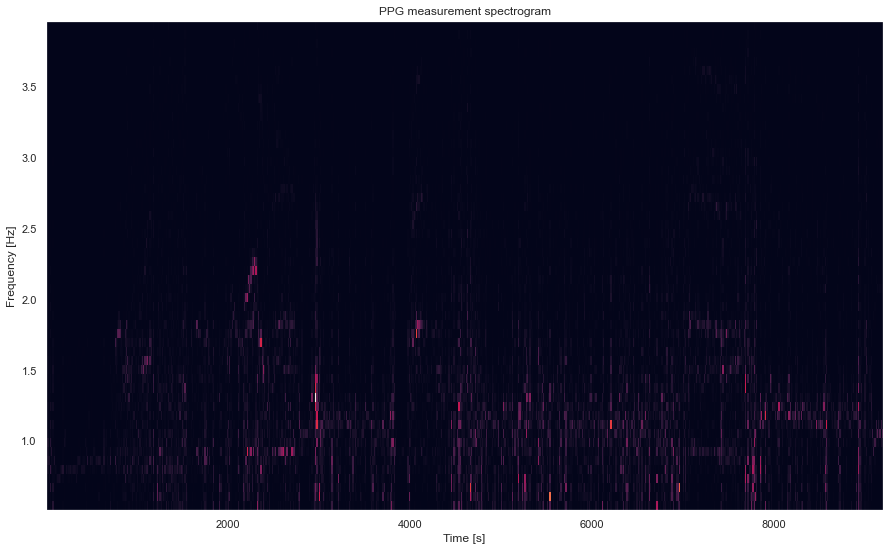

In [117]:
fs_ppg = 64
nperseg_ppg = 1000
noverlap = None
fmin = 0.5 # Hz
fmax = 4 # Hz

ppg, acc, hr, activity, _= unpack_data(datasets[0])

hr_timestamps = np.arange(0, len(hr) * 2, 2)
hr_interpolation = interpolate.interp1d(hr_timestamps, hr)

### create spectrogram
f_ppg, t_ppg, Sxx_ppg = signal.spectrogram(ppg, fs_ppg, nperseg=nperseg_ppg, noverlap=noverlap)

### keep only frequencies of interest
freq_slice_ppg = np.where((f_ppg >= fmin) & (f_ppg <= fmax))
f_ppg = f_ppg[freq_slice_ppg]
Sxx_ppg = Sxx_ppg[freq_slice_ppg,:][0]

# interpolate relevant heart rate measurements
hr_at_ppg_timestamps = hr_interpolation(t_ppg)

### plot ppg spectrogram
plt.figure(figsize=(15, 9))
plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg, shading='flat')
plt.title('PPG measurement spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')

### Compute mutual information between HR and PPG at different frequencies

In [142]:
def compute_mutual_information(Sxx, hr, num_hr_bins, num_power_bins):
    
    result = np.zeros(Sxx.shape[0])

    # compute distribution over heart rates
    hr_dist, hr_bin_edges = np.histogram(hr_at_ppg_timestamps, bins=num_hr_bins)
    hr_dist = hr_dist / sum(hr_dist)

    # iterate over frequencies
    for freq_idx, powers in enumerate(Sxx):
        
        # compute power distribution at given frequency
        power_dist, power_bin_edges = np.histogram(powers, bins=num_power_bins)
        if sum(power_dist) == 0: continue
        power_dist = power_dist / sum(power_dist)

        # iterate over heart rate bins
        for i in range(num_hr_bins):
            
            # retrieve powers in current heart rate bin
            hr_bin_edge_left = hr_bin_edges[i]
            hr_bin_edge_right = hr_bin_edges[i + 1]
            powers_at_given_hr = powers[(hr >= hr_bin_edge_left) & (hr < hr_bin_edge_right)]
            
            # compute conditional probability of powers given heart rate bin
            cond_power_dist, _ = np.histogram(powers_at_given_hr, bins=power_bin_edges)
            if sum(cond_power_dist) == 0: continue
            cond_power_dist = cond_power_dist / sum(cond_power_dist)

            # iterate over power bins
            for j in range(num_power_bins):
                
                if power_dist[j] == 0 or cond_power_dist[j] == 0:
                    continue
                
                result[freq_idx] += cond_power_dist[j] * np.log2(cond_power_dist[j] / power_dist[j])
                break

    return result

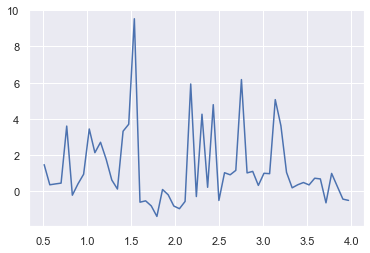

In [200]:
mutual_information_ppg = compute_mutual_information(Sxx_ppg, hr_at_ppg_timestamps, 20, 10)
plt.plot(f_ppg, mutual_information_ppg)

### Run PPG through ADM

In [175]:
up_spikes, down_spikes = ADM(
    ppg,
    up_threshold=50,
    down_threshold=50,
    sampling_rate=fs_ppg,
    refractory_period=0
)

### Reconstruct original signal from ADM-generated spike train

In [192]:
reconstructed_signal = np.zeros(len(ppg))
up_spikes_sampling_rate_indices = (up_spikes * 64).astype(int)
reconstructed_signal[up_spikes_sampling_rate_indices] = 1
reconstructed_signal = gaussian_filter1d(reconstructed_signal, 10)

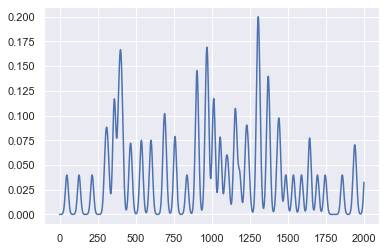

In [195]:
plot_segment_length = 2000
plt.plot(reconstructed_signal[:plot_segment_length])

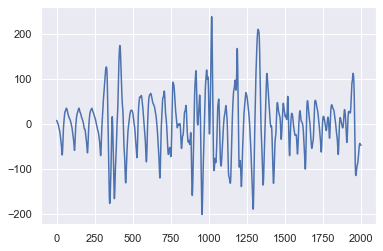

In [196]:
plt.plot(ppg[:plot_segment_length])

### Create spectrogram of reconstructed signal

<ipython-input-197-6344d6c49a39>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg, shading='flat')


Text(0.5, 0, 'Time [s]')

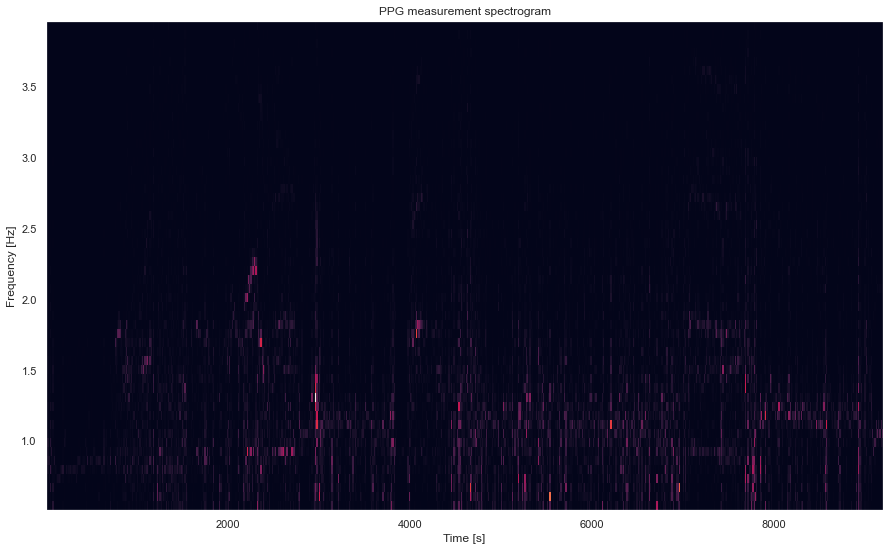

In [197]:
### create spectrogram
f_rec, t_rec, Sxx_rec = signal.spectrogram(reconstructed_signal, fs_ppg, nperseg=nperseg_ppg, noverlap=noverlap)

### keep only frequencies of interest
freq_slice_rec = np.where((f_rec >= fmin) & (f_rec <= fmax))
f_rec = f_rec[freq_slice_ppg]
Sxx_rec = Sxx_rec[freq_slice_ppg,:][0]

# interpolate relevant heart rate measurements
hr_at_ppg_timestamps = hr_interpolation(t_rec)

### plot ppg spectrogram
plt.figure(figsize=(15, 9))
plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg, shading='flat')
plt.title('PPG measurement spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')

### Mutual information between reconstructed PPG and HR

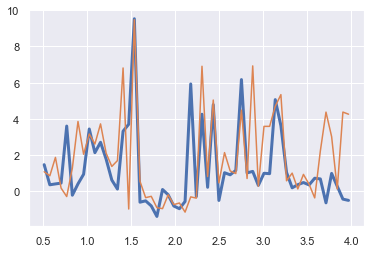

In [205]:
mutual_information_rec = compute_mutual_information(Sxx_rec, hr_at_ppg_timestamps, 20, 10)
plt.plot(f_ppg, mutual_information_ppg, linewidth=3)
plt.plot(f_rec, mutual_information_rec)